#  Goodness of Fit and Deviance

This notebook presents the Poisson's Poisson version of the residual analysis, known as the deviance.

**Sections**
- [1.0 Synthetic Data & Model](#1.0-Synthetic-Data-&-Model)
- [2.0 Newton Raphson Algorithm](#2.0-Newton-Raphson-Algorithm)
- [3.0 Goodness of Fit and Deviance¶](#3.0-Goodness-of-Fit-and-Deviance)

### 0. Importing Modules

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import bokeh
from bokeh.plotting import figure, show
from bokeh.models import tickers, ranges
from bokeh.io import output_notebook
output_notebook()
from scipy.special import factorial
from scipy.stats import chi2
np.seterr(divide='ignore', invalid ='ignore' )

Loading BokehJS ...

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### 1.0 Synthetic Data & Model

$\hspace{80 mm}$ Poisson distribution:

\begin{align}
\large
P(Y = y) = \dfrac{\lambda^{y}}{y}{\rm e}^{-\lambda}
\end{align}

$\hspace{80 mm}$ Will model lambda as a regression function:

\begin{align}
\large
\lambda  = a + bx \\
\end{align}

$\hspace{80 mm}$ However, since we need $ a + bx > 0$, it is more usual to take:

\begin{equation}
\large
\lambda  = {\rm e}^{a + bx} \\
\\
\large
Log \hspace{2 mm} likelihood = L(a,b) = a\hspace{1mm} n \hspace{1mm}\bar y + b\hspace{1mm} z - {\rm e}^{a}\Sigma_{i=1}^{n}{\rm e}^{bx_i}\\
\end{equation}

Steps: <br>
- Model lambda as a regression function
- Sample 100 values from $ X_{i} \sim N(0,1)$
- Get 100 values from  $ \lambda_{i}  = a + bx_{i} $
- Sample 1 value from $ Y_{i} \sim Pois(\lambda_{i})$ for **each i** (i.e., $ \lambda_{i} $)

In [2]:
n = 100
a = 0.5
b = -1
x_i = np.random.normal(0, 1, n)
lambda_vals = np.exp(a + b*x_i)      # shape = 100
y_i = np.random.poisson(lambda_vals) # If size is None (default), a single value is returned if lam is a scalar. 
                                     #  Otherwise, np.array(lam).size samples are drawn. 

# Plotting
p = figure(toolbar_location= None, outline_line_color = 'black')
p.plot_width = 350
p.plot_height = 350
p.scatter(x = x_i, y = y_i, size=8, line_width = 1, line_color = 'black', fill_color = 'firebrick', legend_label="Data")
p.axis.axis_label = 'x'
p.yaxis.axis_label = 'y'
p.legend.border_line_color = "black"
p.legend.border_line_alpha = 1
p.legend.label_text_color = 'black'
show(p)    

### 2.0 Newton Raphson Algorithm

Estimating a and b via maximum likelihood. Helper function to get $J(\theta)$ matrix and $L'(\theta)$ vector

$$
J(a,b)=\begin{pmatrix}
    \dfrac{\partial^2 L}{\partial a^2}   & \dfrac{\partial^2 L}{\partial a \hspace{1mm} \partial b}\\
    \dfrac{\partial^2 L}{\partial a \hspace{1mm} \partial b}   & \dfrac{\partial^2 L}{\partial b^2}
\end{pmatrix} \\
\\
\text{}\\
L'(a,b) = (\dfrac{\partial L}{\partial a}, \dfrac{\partial L}{\partial b})
$$

In [3]:
def get_J_and_Lprime(x_arr, y_arr, a, b, n):
    """
    Computes J matrix and L vector for a Poisson Distribution
    where lambda is model as:
    
    \begin{equation}
    \lambda  = {\rm e}^{a + bx}
    \end{equation}       
    """
    z = np.sum(x_arr*y_arr)

    # Get derivatives for NR
    dL_da = n*np.mean(y_arr) - np.exp(a)*np.sum(np.exp(b*x_arr))
    dL_db = z - np.exp(a)*np.sum(x_arr*np.exp(b*x_arr))

    # Second Partial Derivatives
    dL_da2 = - np.exp(a)*np.sum(np.exp(b*x_arr))
    dL_db2 = - np.exp(a)*np.sum((x_arr**2)*np.exp(b*x_arr))
    dL_dadb = - np.exp(a)*np.sum(x_arr*np.exp(b*x_arr))
    
    J = np.array([[dL_da2,  dL_dadb],
              [dL_dadb, dL_db2]])
    
    L_prime = np.array([[dL_da],[dL_db]])
    return J, L_prime

Compute $J(\theta)$ matrix and $L'(\theta)$ vector for true parameters

In [4]:
J, L_prime = get_J_and_Lprime(x_i, y_i, a, b, n)
print("J matrix:\n", J)
print("\nL_prime vector:\n", L_prime)

J matrix:
 [[-239.54421851  171.60103611]
 [ 171.60103611 -256.61252605]]

L_prime vector:
 [[15.45578149]
 [ 1.04427316]]


Algorithm function

In [5]:
def newton_n_iter(x, y, a_o, b_o,  tolerance = 0.00001, output_message = False):
    """
    Performs Newton-Raphson for a definite number of iteration
    Args:
        guess (float): initial value for parameter
        tolerance (float): tolerance
    
    """
    #Initialize
    a = [a_o]
    b = [b_o]
    difference = tolerance * 5 # Enter Loop
    iter_number = 0
    status_message = 'Starting with Guess = ' + str(a_o) + "," + str(b_o) + '\n'

    while abs(difference) > tolerance:
    
        J, L = get_J_and_Lprime(x_i, y_i, a_o, b_o, n)
   
        a_1 ,b_1 = np.array([[a_o],[b_o]]) - np.linalg.inv(J) @ L
        a.append(a_1[0])
        b.append(b_1[0])
        
        # calculate difference and update iteration state
        difference = max(a_1[0] - a_o, b_1[0] - b_o)
        a_o, b_o = a_1[0], b_1[0]
    
        iter_number += 1
        status_message += 'Iteration #' + str(iter_number) + ':= ' + str(a_1[0]) + "," + str(b_1[0])+ '\n'
        
    status_message += 'Total No. of Iterations = '  +  str(iter_number)
    
    if output_message:
        return a_o, b_o, status_message, a, b
    return a_o, b_o, a, b

### 3.0 Goodness of Fit and Deviance

In [6]:
n = 20
a = 0.5
b = -1
x_i = np.random.normal(0, 1, n)
lambda_vals = np.exp(a + b*x_i)
sat_log_arr = []
MLE_arr = []
deviance = []

for _ in range(1000):
    
    y_i = np.random.poisson(lambda_vals) 
    a_o, b_o, _, _ = newton_n_iter(x_i, y_i, 1.6, 2)
                
    # Saturated Log-likelihood
    values =   y_i*np.log(y_i) - y_i - np.log(factorial(y_i))
    values = np.where(np.isnan(values), 0, values)        
    sat_log = np.sum(values)
    
    # MLE fitted log-likelihood
    lambda_i = np.exp(a_o + b_o*x_i)
    MLE = np.sum(y_i*np.log(lambda_i) - lambda_i - np.log(factorial(y_i)))
        
    deviance.append(2 * (sat_log - MLE))

    sat_log_arr.append(sat_log)
    MLE_arr.append(MLE)

In [7]:
def plot_hist(x, name, df):
    if type(x).__name__ == 'list':
        x = np.array(x)
    fig, ax = plt.subplots(1, 1)
    ax.hist(x, bins=12, color='c', edgecolor='k', alpha=0.65,density = True)
    plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(x.mean()))
    plt.xlabel(name); 
    plt.ylabel('Density'); 
    
    # Add Chi-square
    x = np.arange(0,50,0.5)
    ax.plot(x, chi2.pdf(x, df),'r-', lw=5, alpha=0.6, label='chi2 pdf')
        
    plt.show()

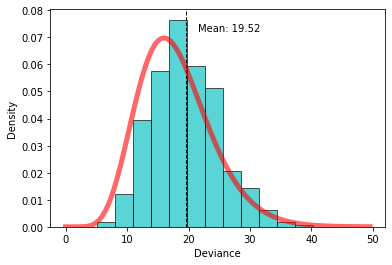

In [8]:
plot_hist(deviance, 'Deviance', 18)

#### 3.1 Purposely testing the same data model with $ b = 0$

In [23]:
n = 20
a = 0.5
b = 1
x_i = np.random.normal(0, 1, n)
lambda_vals = np.exp(a + b*x_i)
sat_log_arr = []
MLE_arr = []
deviance = []

for _ in range(1000):
    
    y_i = np.random.poisson(lambda_vals) 
    a_o, b_o, _, _ = newton_n_iter(x_i, y_i, 1.6, 2)
                
    # Saturated Log-likelihood
    values =   y_i*np.log(y_i) - y_i - np.log(factorial(y_i))
    values = np.where(np.isnan(values), 0, values)        
    sat_log = np.sum(values)
    
    # MLE fitted log-likelihood
    lambda_i = np.exp(a_o + 0*x_i)
    MLE = np.sum(y_i*np.log(lambda_i) - lambda_i - np.log(factorial(y_i)))
        
    deviance.append(2 * (sat_log - MLE))

    sat_log_arr.append(sat_log)
    MLE_arr.append(MLE)

Computing some deviance samples, the mean of which turns out to be much larger than the specified degrees of freedom, **indicating a problem with the model**.

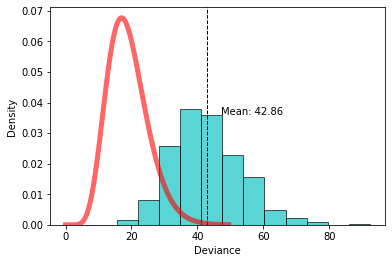

In [24]:
plot_hist(deviance, 'Deviance', 19)